<a href="https://colab.research.google.com/github/tammy-uncc/ITCS6162KDDGroup4/blob/main/KDD_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ITCS 6162 KDD Group 4 Final Project
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

## Introduction

Group 4 decided that they would like to research the possibility of whether an individual could change their lifestyle factors in time to reduce or eliminate the onset of Alzheimer's. For example, if an individual knew that a healthier diet could reduce their chance of a positive diagnosis, then they may put eating healthier as an earlier priority in their lives. This dataset includes many lifestyle factors (BMI, smoking status, alcohol consumption, physical activity, diet quality, and sleep quality) that will help in building predictive and prescriptive objectives.
We will be using supervised learning methods as the diagnosis of Alzheimer's is a known outcome in this dataset.

We will be looking into classification, clustering, and feature selection to identify and select the most relevant features to improve the predictive models. By using these approaches, group 4 hopes that this research will uncover any insights of lifestyle risk factors for developing Alzheimer’s and which lifestyle factor modifications could mitigate those risks.




## Team Members
Julie Berryhill<br>
Manoj Aitha<br>
Gabriel Van Dreel<br>
Tammy Ziegler<br>
Dasha Rizvanova<br>

## Research Question


## Data Source
https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset?select=alzheimers_disease_data.csv

The dataset consists of 2150 entries detailing various physiological characteristics of patients who were considered for an Alzheimer’s disease diagnosis and whether they were formally diagnosed with the illness. Some of the data such as the gender and ethnicity columns is categorical while other data is numeric and represents either an index for a rating of some condition such as sleep quality or a direct measurement of some physical characteristic such as cholesterol. All of the numeric data points could be considered time series data with respect to age. Some columns in the dataset such as the name of the doctor in charge of a given patient, however, have been sanitized and provide no meaningful information.

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import the required modules

In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
from statistics import mean
import numpy as np


## Load the data

In [ ]:
# Load the data

df = pd.read_csv('/content/drive/MyDrive/ITCS 6162/alzheimers_disease_data.csv')

### Drop the unnecessary features.

In [ ]:
df = df.drop(['DoctorInCharge','PatientID'], axis=1)
df.head()


,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,6.045039,0,0,0.014691,0,0,1,1,0,0


## Analize the data.

### Perform correlations with groups of data




<Axes: title={'center': 'All'}>

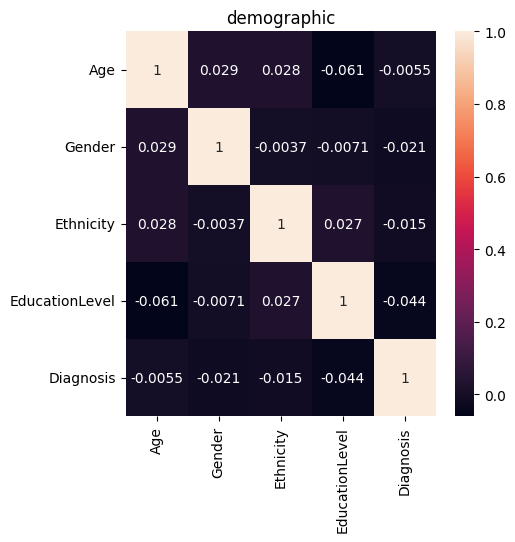

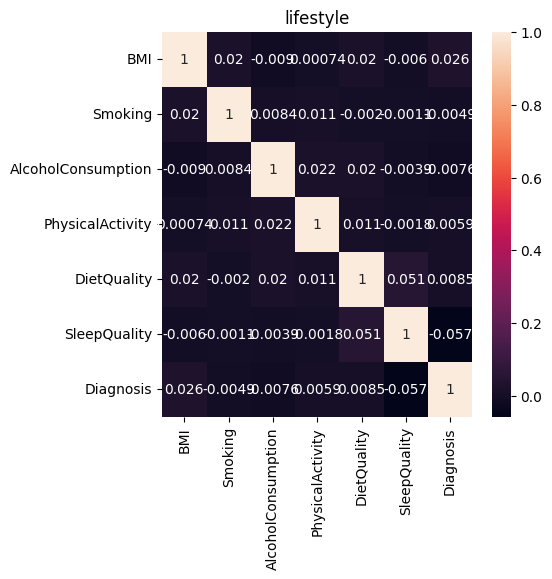

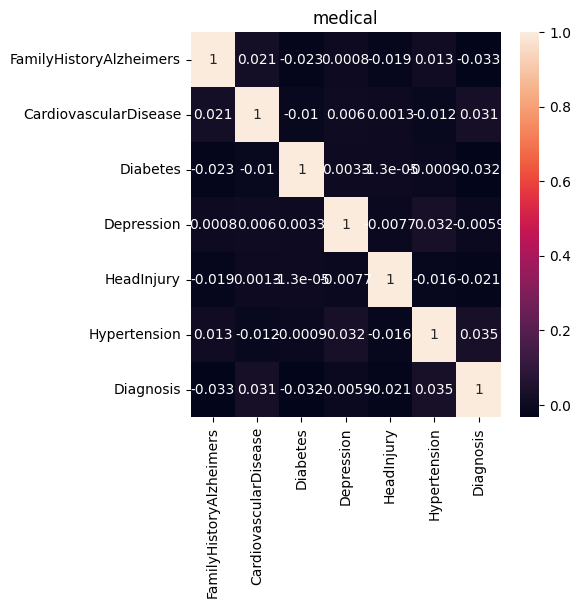

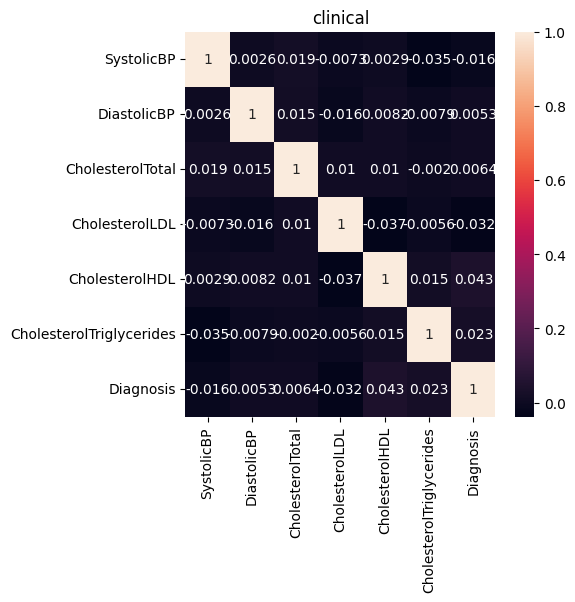

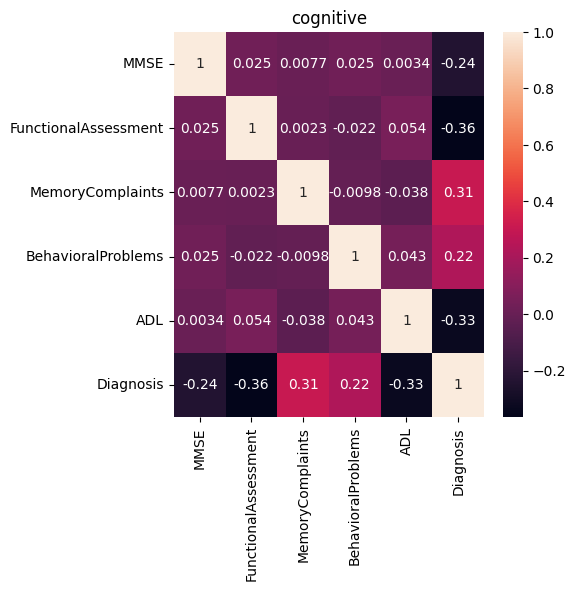

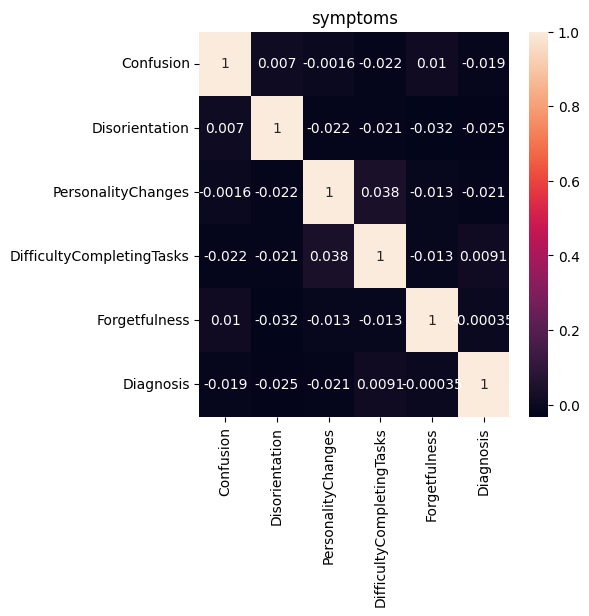

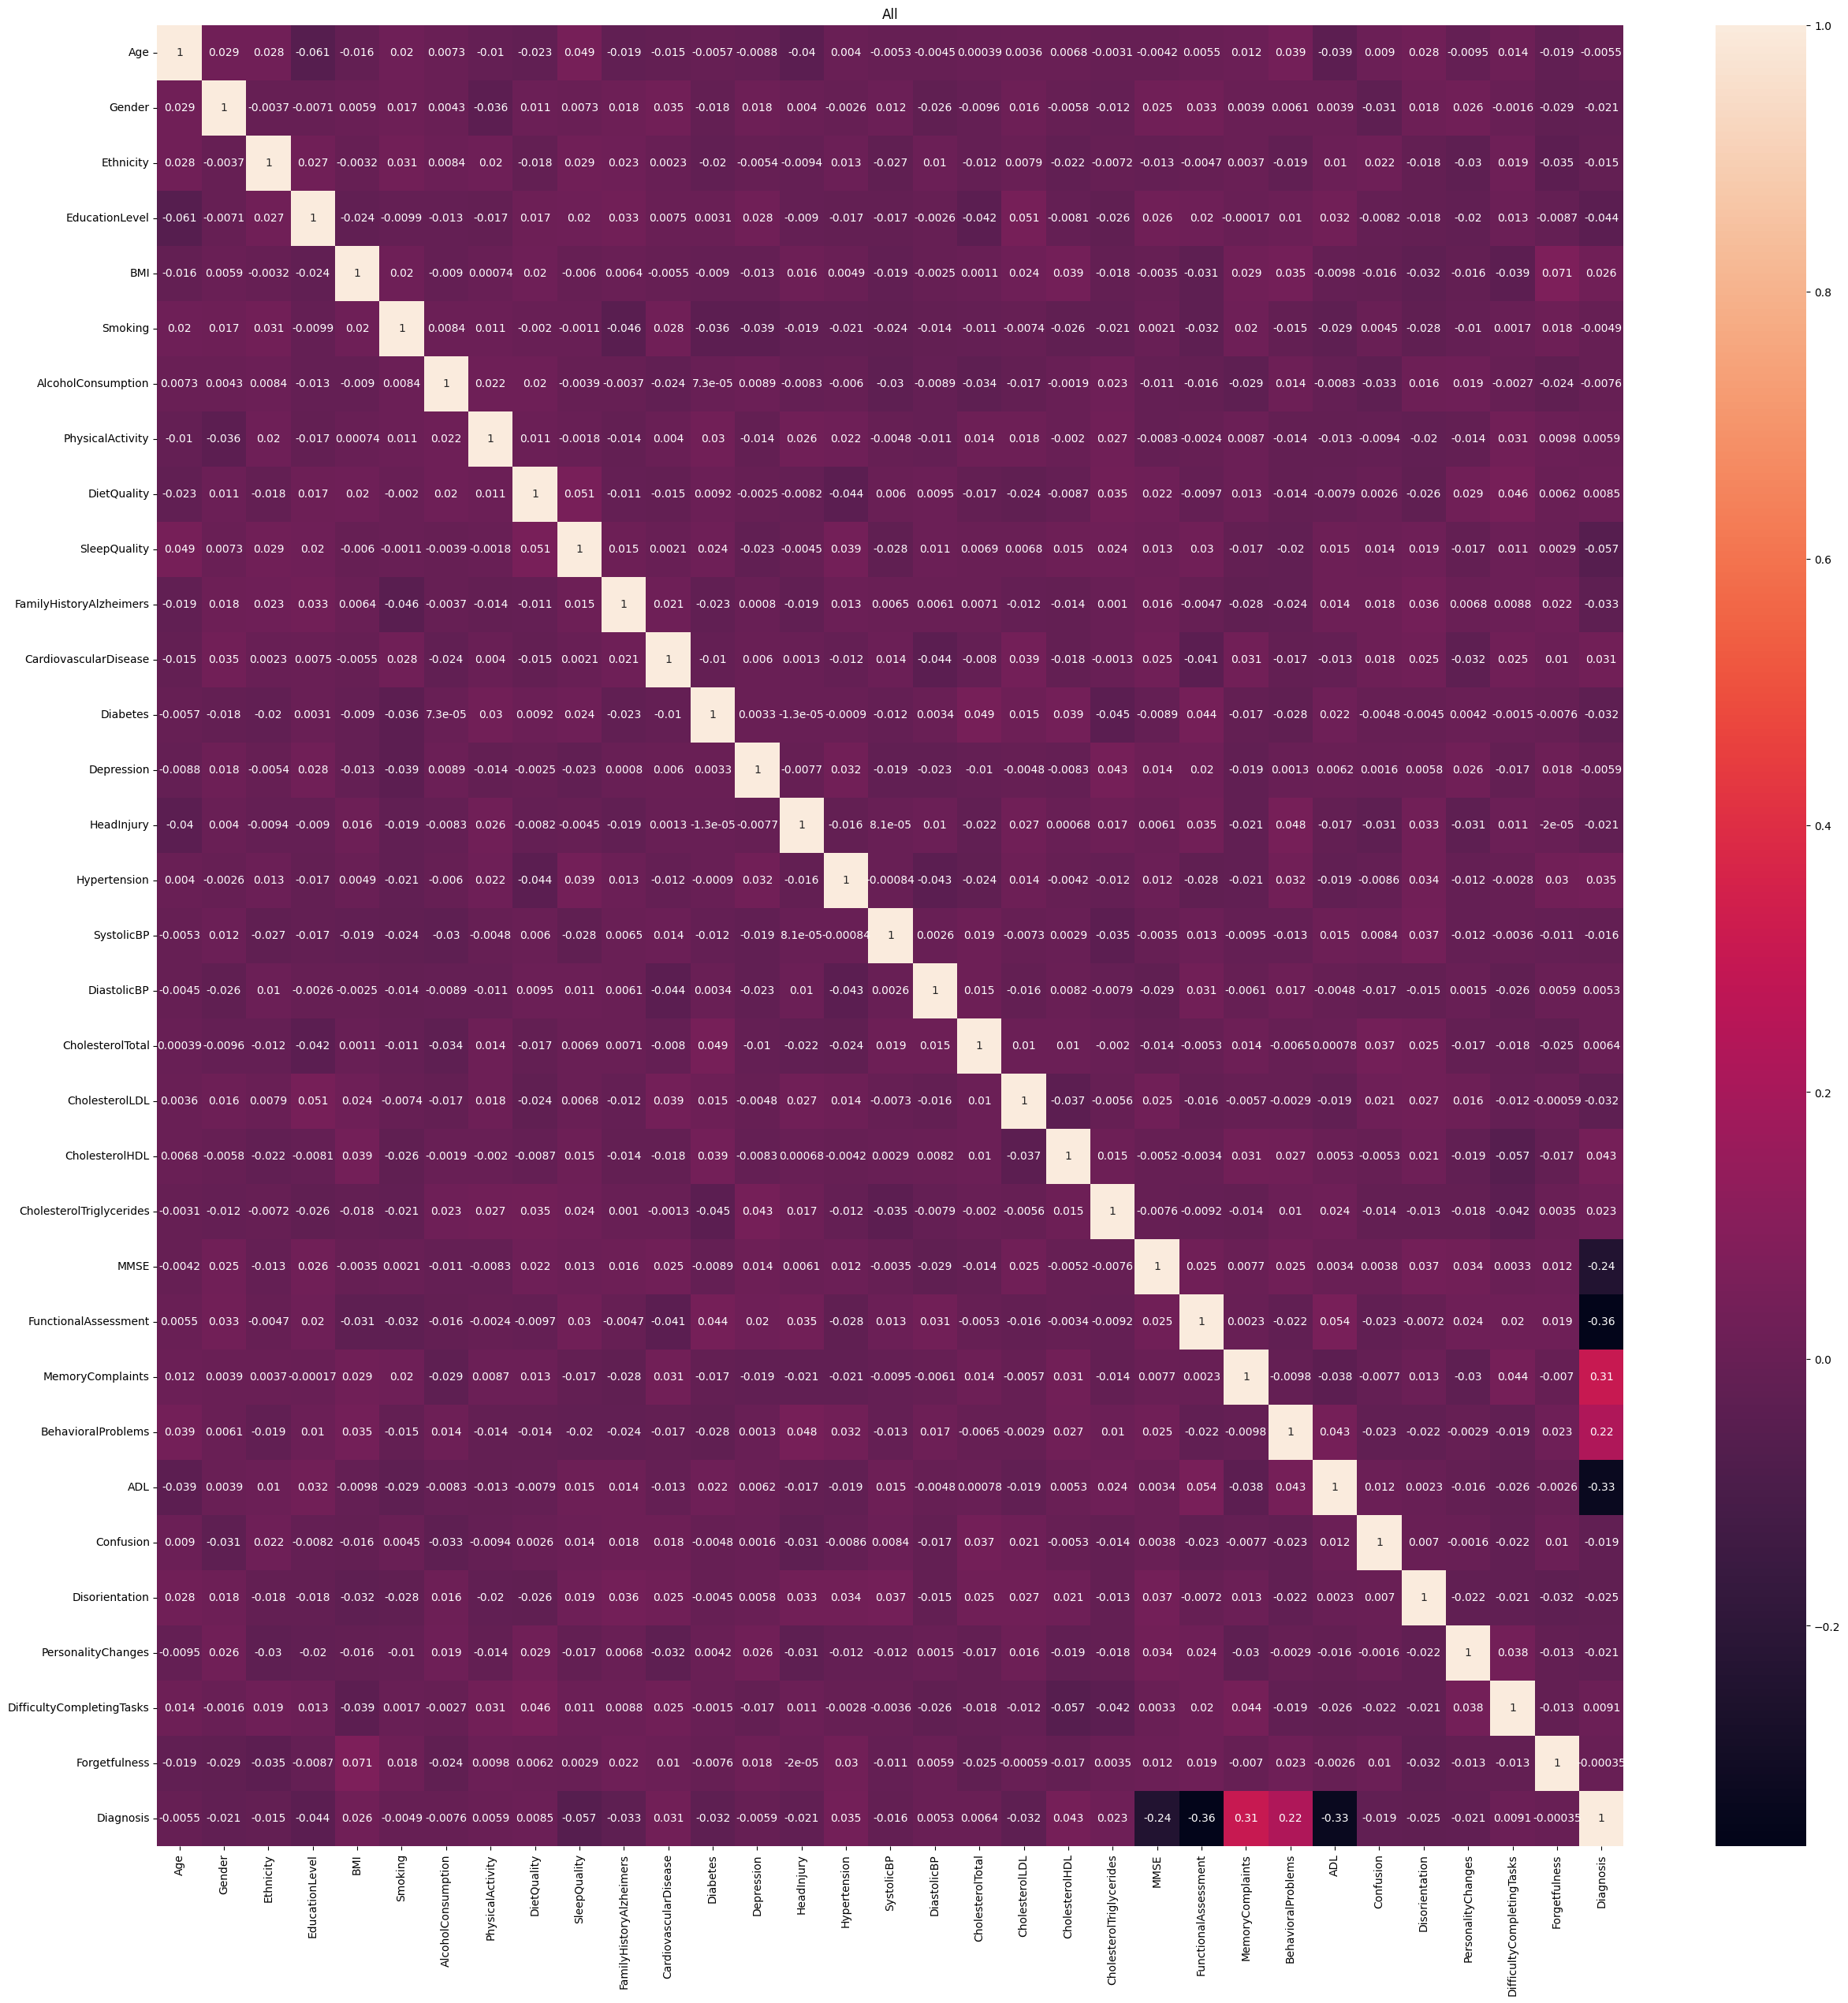

In [ ]:
groups = {'demographic': df[['Age','Gender','Ethnicity','EducationLevel','Diagnosis']],
'lifestyle': df[['BMI','Smoking','AlcoholConsumption','PhysicalActivity',
                'DietQuality', 'SleepQuality','Diagnosis']],
'medical' : df[['FamilyHistoryAlzheimers','CardiovascularDisease', 'Diabetes',
              'Depression', 'HeadInjury', 'Hypertension','Diagnosis']],
'clinical' : df[['SystolicBP', 'DiastolicBP','CholesterolTotal',
               'CholesterolLDL', 'CholesterolHDL','CholesterolTriglycerides',
               'Diagnosis']],
'cognitive' : df[['MMSE', 'FunctionalAssessment','MemoryComplaints',
                'BehavioralProblems', 'ADL','Diagnosis']],
'symptoms' : df[['Confusion','Disorientation', 'PersonalityChanges',
               'DifficultyCompletingTasks', 'Forgetfulness','Diagnosis']]
}

for group in groups:
  corr = groups[group].corr()
  plt.figure(figsize=(5,5))
  plt.title(group)
  sns.heatmap(corr,annot=True)


corr = df.corr()
plt.figure(figsize=(30,30))
plt.title('All')
sns.heatmap(corr,annot=True)



### Perform density analysis

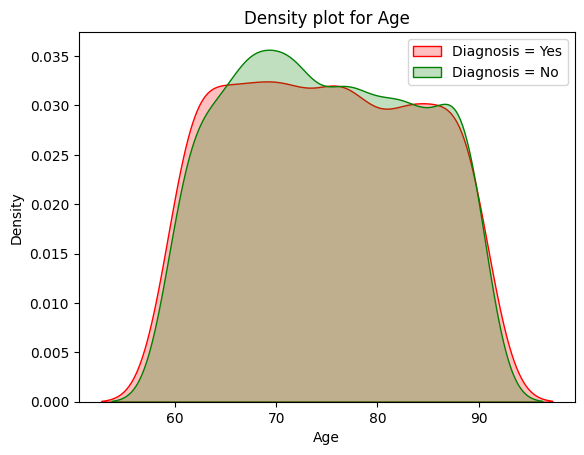

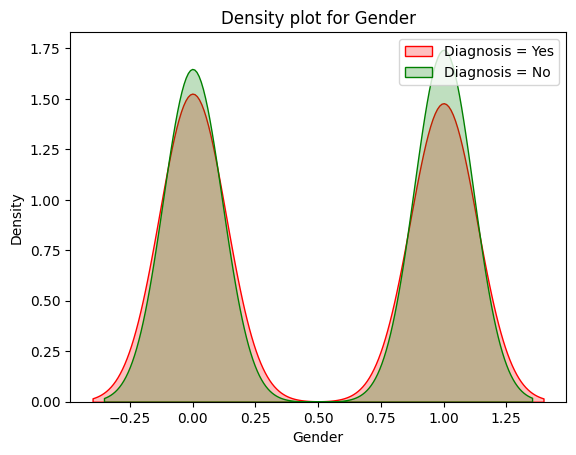

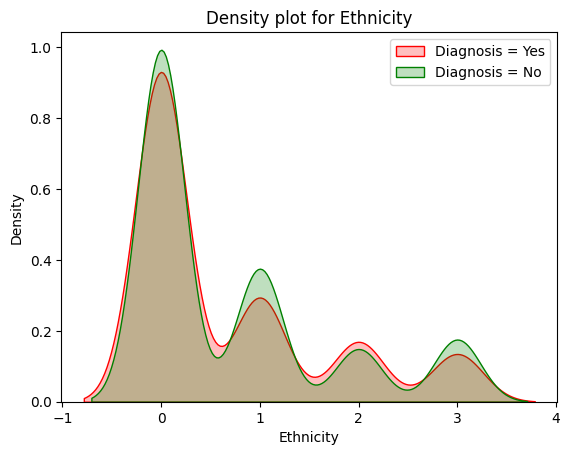

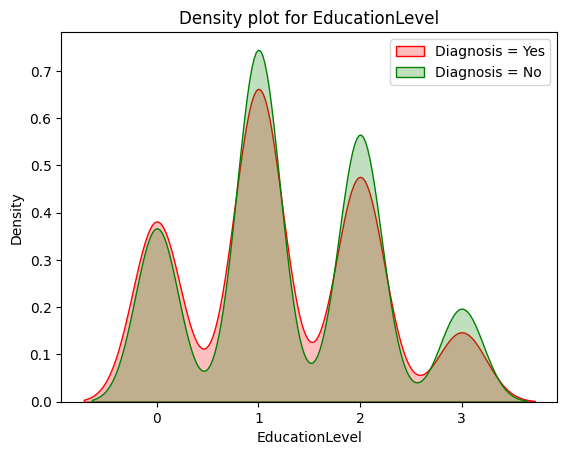

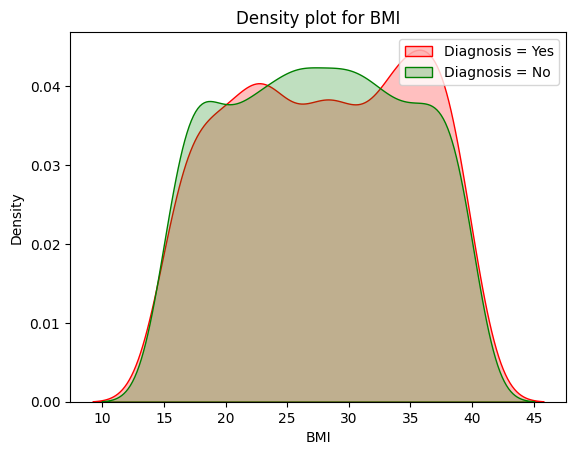

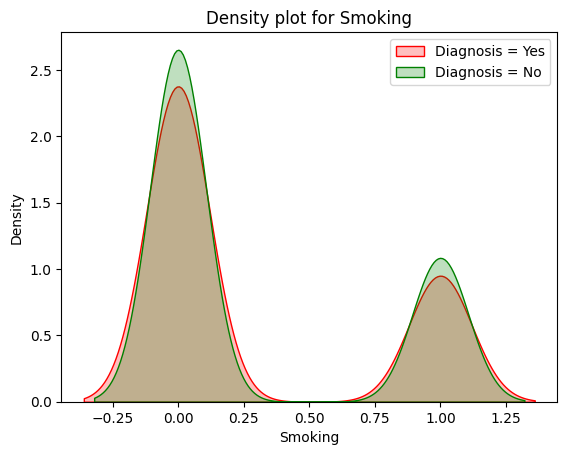

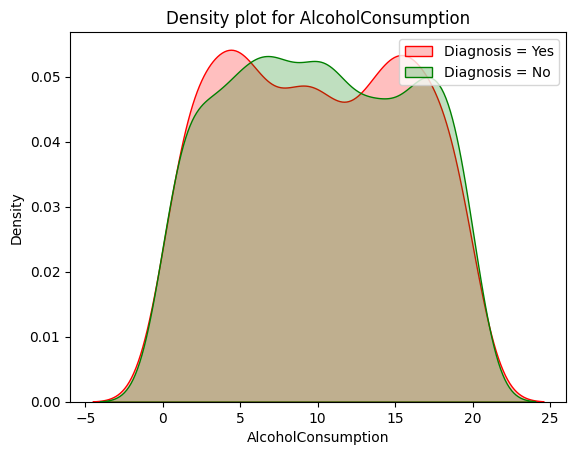

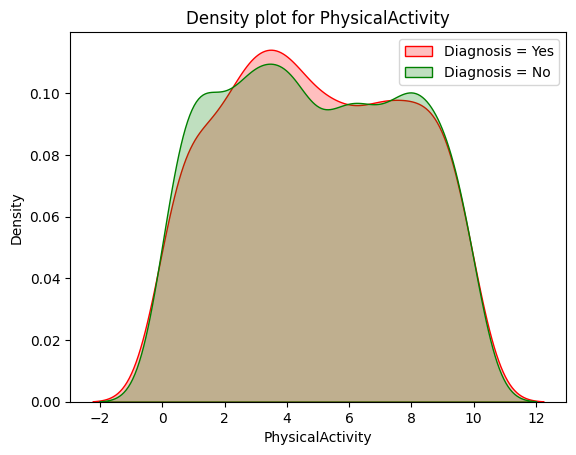

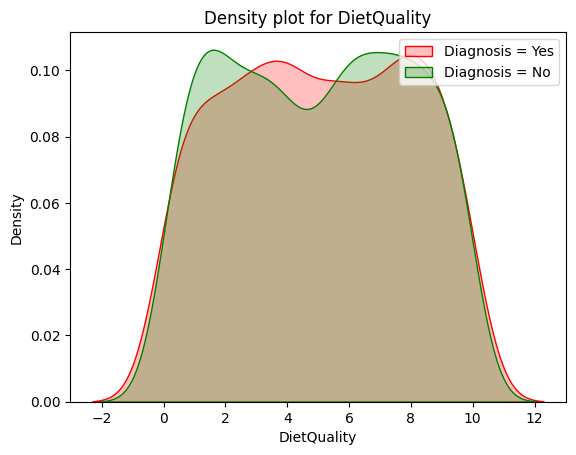

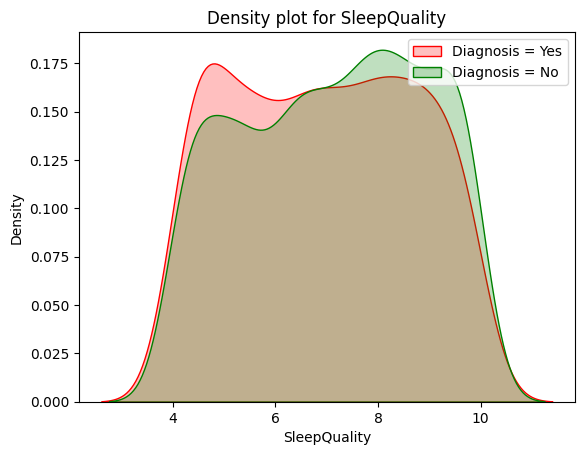

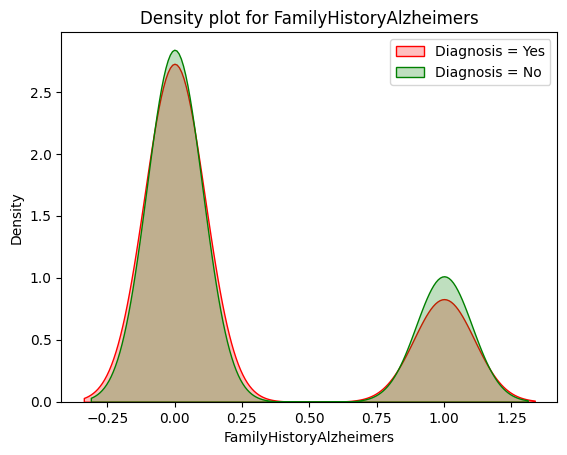

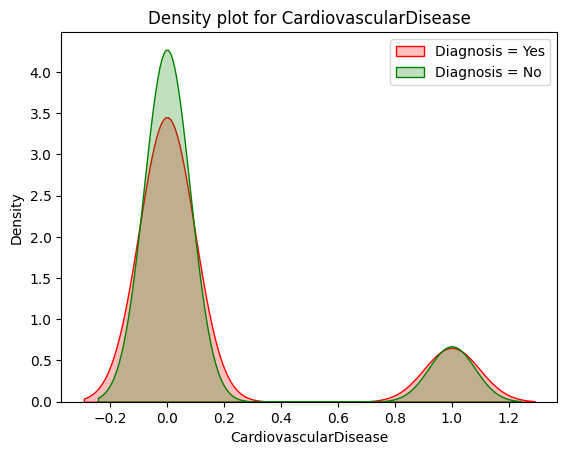

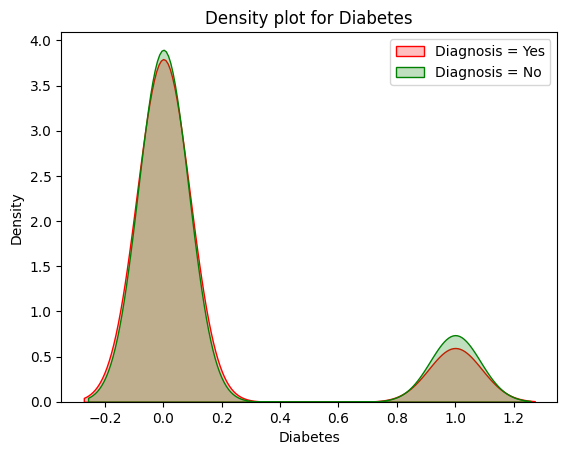

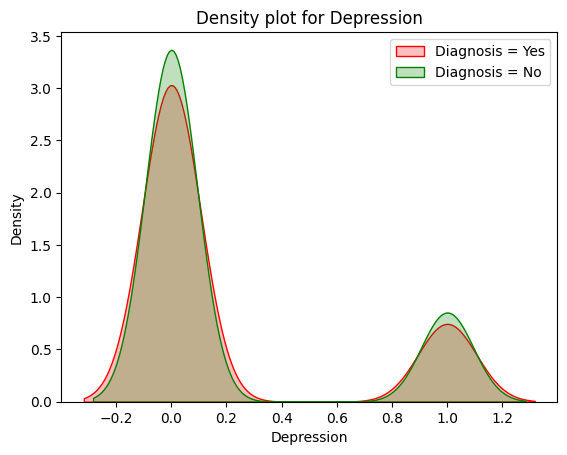

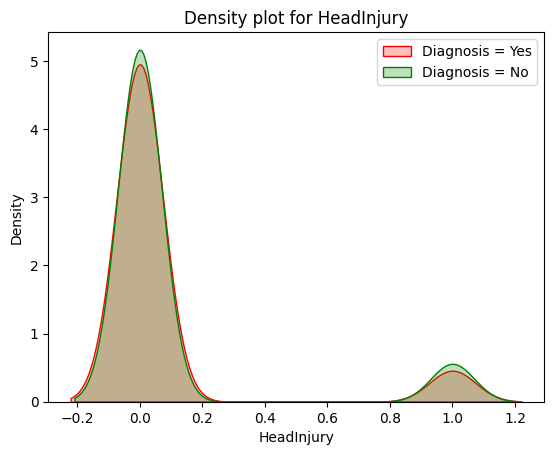

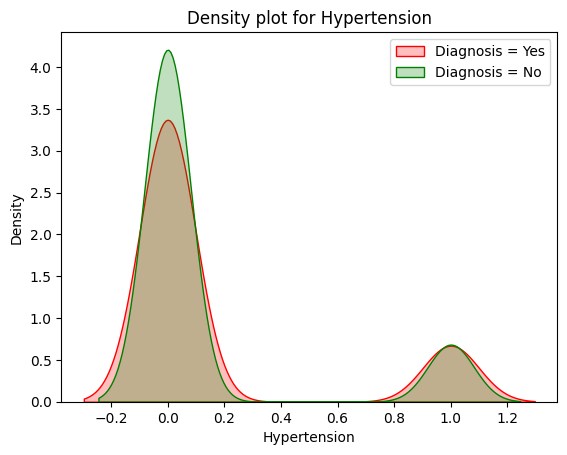

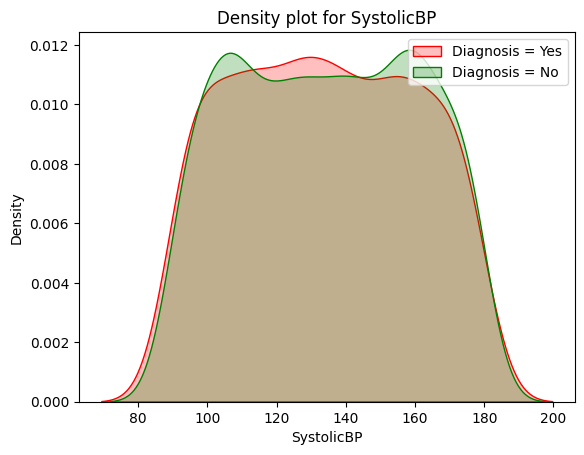

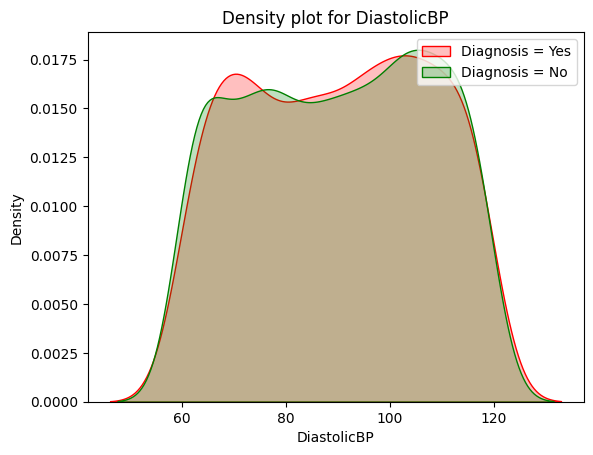

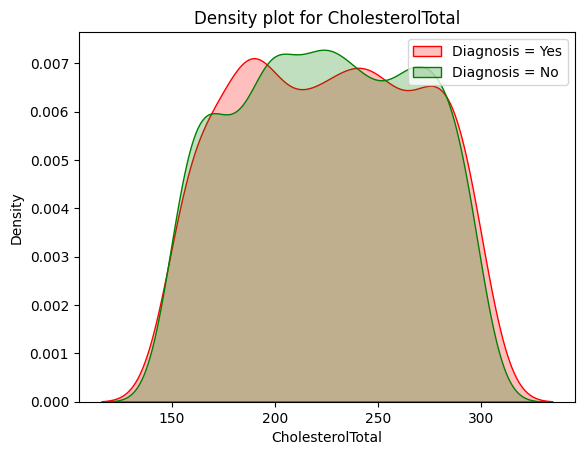

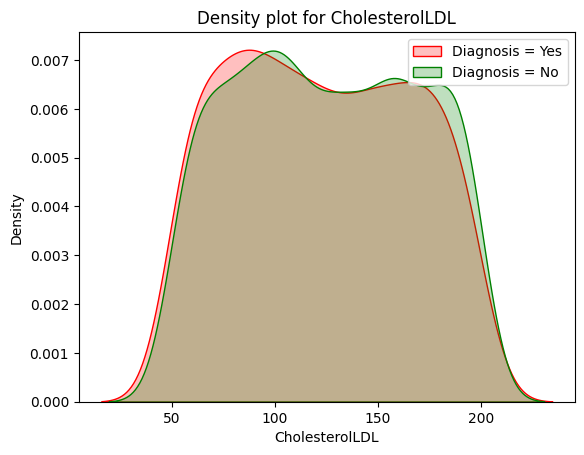

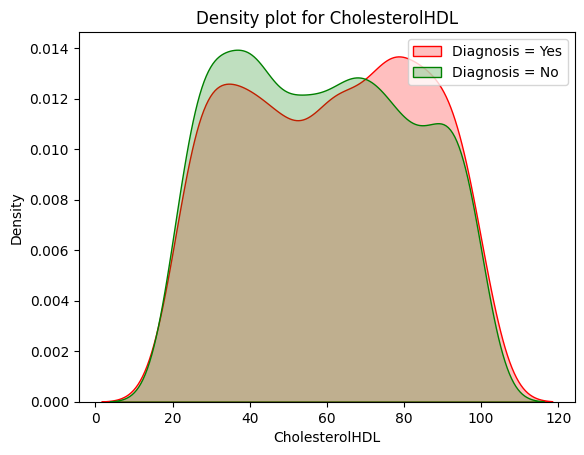

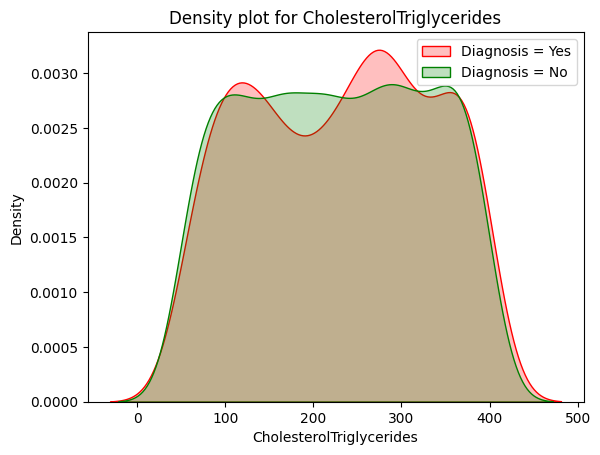

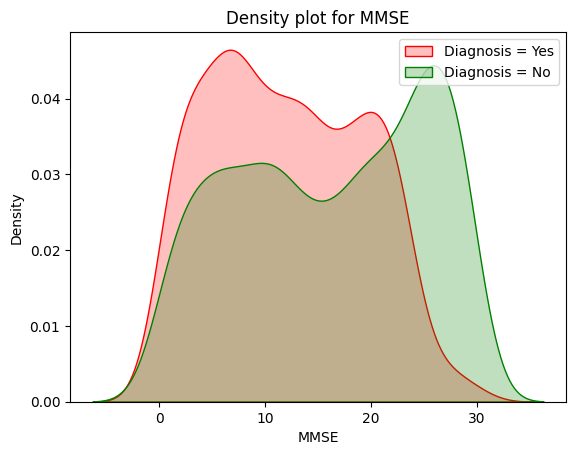

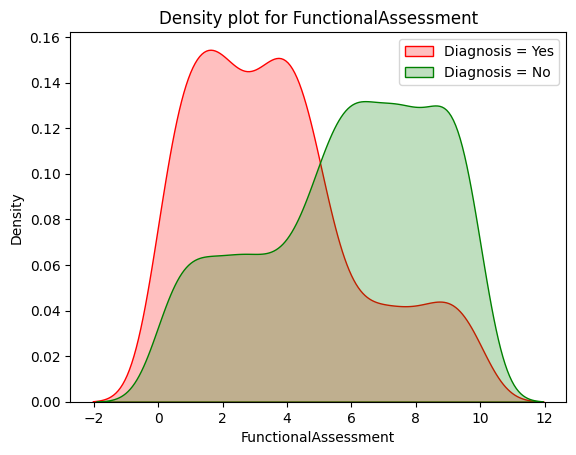

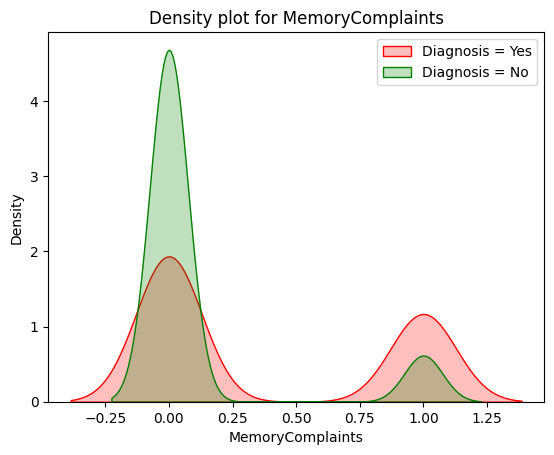

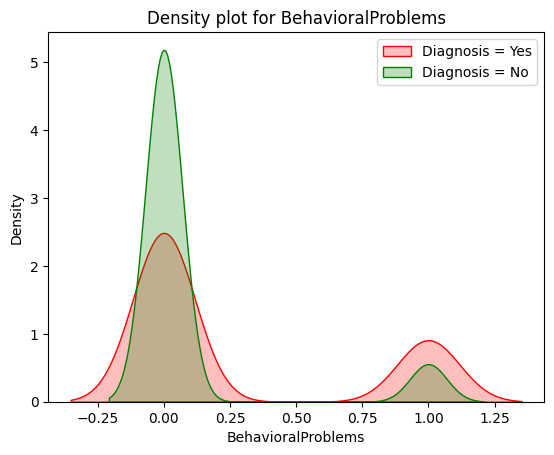

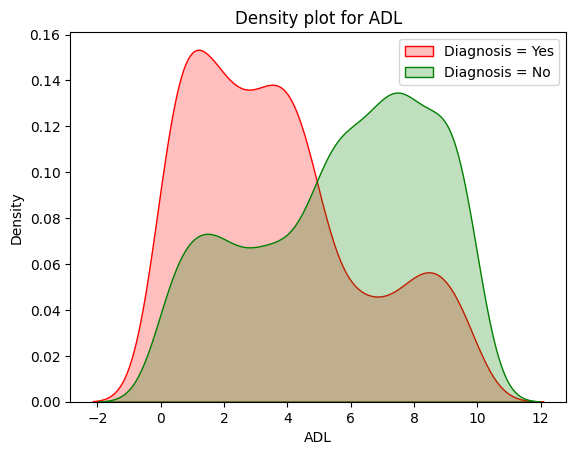

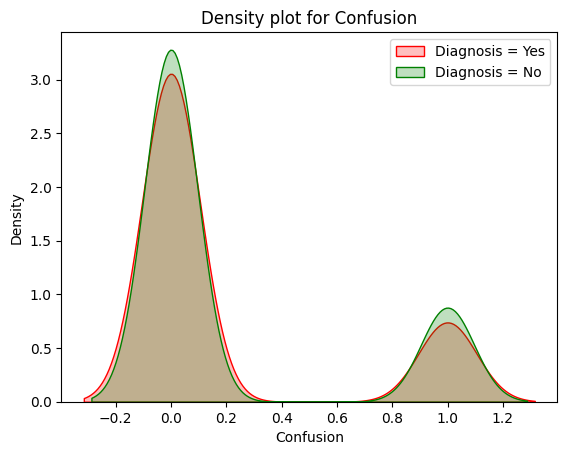

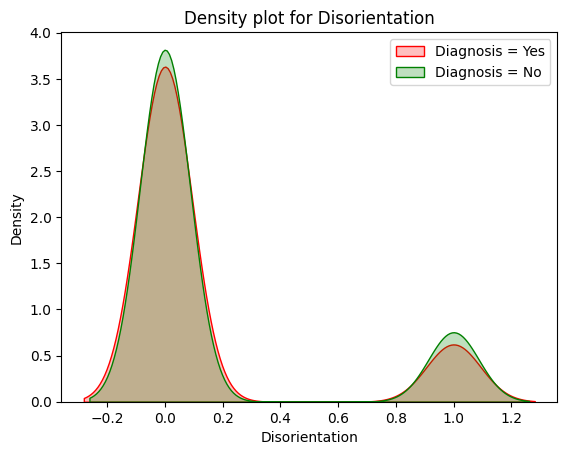

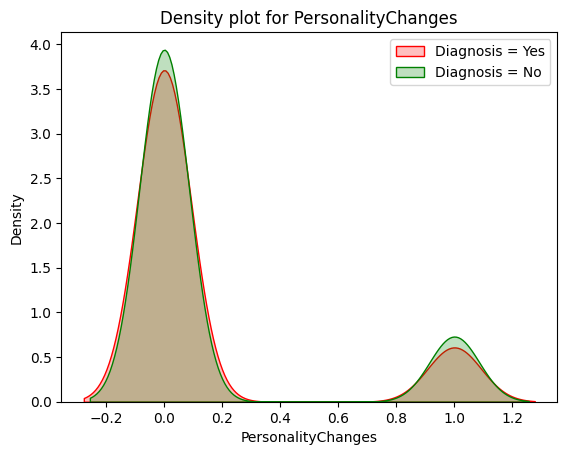

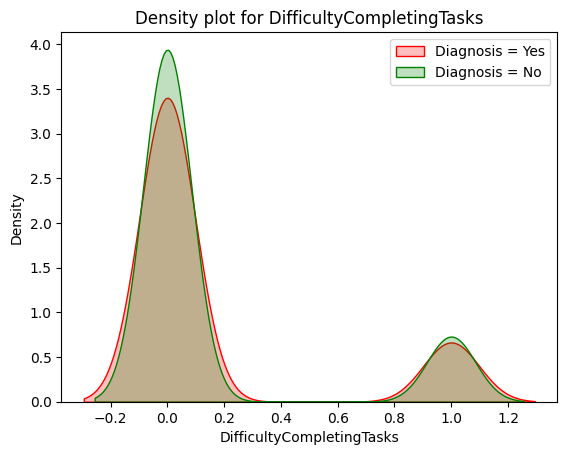

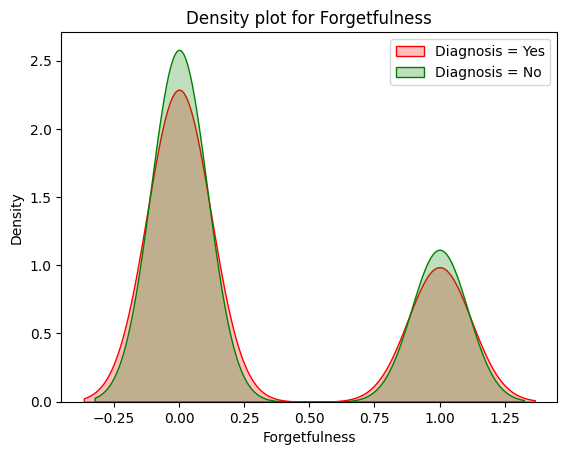

In [ ]:

for col in df.columns:
  if col == 'Diagnosis': continue
  sns.kdeplot(df[df['Diagnosis']==1][col], color='red',fill=True)
  sns.kdeplot(df[df['Diagnosis']==0][col], color='green',fill=True)
  plt.title(f'Density plot for {col}')
  plt.legend(['Diagnosis = Yes', 'Diagnosis = No'])
  plt.show()



